# Activitiy Clustering

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
import warnings
import editdistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
import jellyfish
import matplotlib.pyplot as plt
from math import floor, ceil

warnings.filterwarnings('ignore') # Remove warnings

In [2]:
#CASE_ID = "Auftragsnr.-Artikelnr."
CASE_ID = 'case'
ACTIVITY_ID = 'activity'

#df = pd.read_csv("../data/Auswertung_März_merged_Auftragsnr.-Artikelnr.csv", sep=";", dtype='unicode')
df = pd.read_csv("../../perfsky/data/daily.2019-July_September.csv", sep=",", dtype='unicode')

print('Data set contains:')
print('- ',len(df),'events')
print('- ',len(df['case'].unique()),'cases')
print('- ',len(df[ACTIVITY_ID].unique()),'activities')

avg_activities = df[CASE_ID].value_counts().mean()
print("- Avg. events per case: ", avg_activities)

# Convert to event log
df.rename(columns={CASE_ID: 'case:concept:name',
                   ACTIVITY_ID: 'concept:name',
                   "start_timestamp": "time:timestamp"}, inplace=True)
temp = dataframe_utils.convert_timestamp_columns_in_df(df)
log = log_converter.apply(temp)
df.head()

Data set contains:
-  61914 events
-  50 cases
-  262 activities
- Avg. events per case:  1238.28


,Unnamed: 0,case:concept:name,concept:name,start_time,end_time
0,0,daily.2019-09-24_05-05-02,AllTasks,2019-09-24 05:05:32+00:00,2019-09-24 16:55:33+00:00
1,1,daily.2019-09-24_05-05-02,DumpTask(sql_filename=regular_urls)(kvs=None)(...,2019-09-24 05:20:10+00:00,2019-09-24 05:40:21+00:00
2,2,daily.2019-09-24_05-05-02,DumpTask(sql_filename=reprocess_urls)(kvs=None...,2019-09-24 05:20:10+00:00,2019-09-24 05:21:03+00:00
3,3,daily.2019-09-24_05-05-02,DumpTask(sql_filename=daily_urls)(kvs=None)(ch...,2019-09-24 05:20:10+00:00,2019-09-24 05:21:32+00:00
4,4,daily.2019-09-24_05-05-02,ProxySetupTask,2019-09-24 05:20:10+00:00,2019-09-24 05:32:45+00:00


In [3]:
# Parameters

TRACE_SETS = False
DISTANCE = "edit" # "jaro", "dam_lev", "lev", "lcs", "edit", "lev"
ALGORITHM = "agglomerative" # "agglomerative", "dbscan"
N_CLUSTERS = 50

# Used for Agglomerative Clustering
# ‘average’ uses the average of the distances of each observation of the two sets.
# ‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the
# ‘ward’ minimizes the variance of the clusters being merged. two sets.
#‘ single’ uses the minimum of the distances between all observations of the two sets.
LINKAGE = "complete" # "ward", "complete", "average", "single"

In [4]:
from pm4py.statistics.traces.generic.log import case_statistics

variants_count = case_statistics.get_variant_statistics(log)
variants_table = pd.DataFrame.from_dict(variants_count)
variants_table['variant_list'] = variants_table.apply(lambda x: x['variant'].split(','), axis=1)
#print(len(variants_table))
#variants_table.head()

In [5]:
activities = variants_table['variant_list']

In [6]:
# Dynamic Programming implementation of LCS problem
def lcs_dist(X, Y):
    # find the length of the strings
    m = len(X)
    n = len(Y)
 
    # declaring the array for storing the dp values
    L = [[None]*(n + 1) for i in range(m + 1)]
 
    """Following steps build L[m + 1][n + 1] in bottom up fashion
    Note: L[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
 
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1]
    return L[m][n]

def lev_dist(a, b):
    '''
    This function will calculate the levenshtein distance between two input
    strings a and b
    
    params:
        a (String) : The first string you want to compare
        b (String) : The second string you want to compare
        
    returns:
        This function will return the distnace between string a and b.
        
    example:
        a = 'stamp'
        b = 'stomp'
        lev_dist(a,b)
        >> 1.0
    '''
    
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

"""
Compute the Damerau-Levenshtein distance between two given
strings (s1 and s2)
"""
def damerau_levenshtein_distance(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost) # transposition
    
    return d[lenstr1-1,lenstr2-1]

 
# Function to calculate the Jaro Similarity of two array
def jaro_distance(s1, s2):
     
    # If the s are equal
    if (s1 == s2):
        return 1.0
 
    # Length of two s
    len1 = len(s1)
    len2 = len(s2)
 
    # Maximum distance upto which matching
    # is allowed
    max_dist = floor(max(len1, len2) / 2) - 1
 
    # Count of matches
    match = 0
 
    # Hash for matches
    hash_s1 = [0] * len(s1)
    hash_s2 = [0] * len(s2)
 
    # Traverse through the first
    for i in range(len1):
 
        # Check if there is any matches
        for j in range(max(0, i - max_dist),
                       min(len2, i + max_dist + 1)):
             
            # If there is a match
            if (s1[i] == s2[j] and hash_s2[j] == 0):
                hash_s1[i] = 1
                hash_s2[j] = 1
                match += 1
                break
 
    # If there is no match
    if (match == 0):
        return 0.0
 
    # Number of transpositions
    t = 0
    point = 0
 
    # Count number of occurrences
    # where two characters match but
    # there is a third matched character
    # in between the indices
    for i in range(len1):
        if (hash_s1[i]):
 
            # Find the next matched character
            # in second
            while (hash_s2[point] == 0):
                point += 1
 
            if (s1[i] != s2[point]):
                t += 1
            point += 1
    t = t//2
 
    # Return the Jaro Similarity
    return (match/ len1 + match / len2 +
            (match - t) / match)/ 3.0

In [7]:
activities = df['concept:name'].unique()

In [8]:
def compute_distance_matrix(variants, distance=DISTANCE):
    #tid = [','.join(x) for x in variants.tolist()]
    tid = variants
    distance_matrix = []
    for i, variant in enumerate(variants):
        distances_per_source = []            
        if i > 0:
            distances_per_source.extend([-1 for v in range(i)])
        if i == len(variants):
            distances_per_source.append(0)
            distance_matrix.append(distances_per_source)
        else:
            for j, successor in enumerate(variants[i:]):
                if distance == "edit":
                    distances_per_source.append(editdistance.eval(variant, successor))
                elif distance == "lcs":
                    distances_per_source.append(lcs_dist(variant, successor))
                elif distance == "lev":
                    distances_per_source.append(lev_dist(variant, successor))
                elif distance == "dam_lev":
                    distances_per_source.append(damerau_levenshtein_distance(variant, successor))
                elif distance == "jaro": 
                    distances_per_source.append(jaro_distance(variant, successor))
                else:
                    raise ValueError("Unkonw distance")
                    
            distance_matrix.append(distances_per_source)        
    distance_matrix= np.array(distance_matrix)
    iu = np.triu_indices(len(variants),1)
    il = (iu[1],iu[0])
    distance_matrix[il]=distance_matrix[iu]

    return distance_matrix, tid 
                                    

if TRACE_SETS:
    variants = variants_table['variant_list']
    variants = variants.apply(lambda v: list(set(v))).drop_duplicates()
else:
    variants = variants_table['variant_list']
    
distance_matrix, tid  = compute_distance_matrix(activities, DISTANCE)
print(len(tid))
print(distance_matrix.shape)

262
(262, 262)


In [9]:
print(len(distance_matrix), len(distance_matrix[0]))
distance_matrix

262 262


array([[ 0, 51, 53, ..., 18, 15,  5],
       [51,  0,  7, ..., 43, 45, 53],
       [53,  7,  0, ..., 46, 47, 55],
       ...,
       [18, 43, 46, ...,  0,  8, 17],
       [15, 45, 47, ...,  8,  0, 15],
       [ 5, 53, 55, ..., 17, 15,  0]])

In [10]:
clustering = AgglomerativeClustering(linkage=LINKAGE, affinity='precomputed', n_clusters=N_CLUSTERS).fit(distance_matrix)
clustering.labels_

array([16,  7,  7,  7,  3,  9,  7, 45, 42,  3, 43, 42,  3, 42,  9, 18, 18,
       28, 28, 43, 42, 15, 15, 43, 42, 43, 42, 40,  8, 36,  8,  8, 11, 11,
       11, 14, 11, 14, 14, 14, 23, 23, 43, 42, 43, 42, 43, 42, 43, 42, 46,
       42, 43, 42, 43, 42, 43, 42, 42, 43, 43, 42, 43, 42, 23, 23, 43, 42,
       43, 42, 43, 42, 43, 42, 43, 42, 43, 42, 43, 42, 43, 42, 43, 42, 43,
       42, 43, 42, 43, 42, 43, 42, 43, 42, 43, 42, 43, 42, 43, 42, 43, 42,
       43, 42, 43, 39, 39, 37, 39, 37, 43,  7, 37, 35, 43, 17,  3, 17, 30,
        0, 30,  6,  0, 16, 16, 19, 15, 19, 12, 12, 16, 16, 32, 32,  4,  8,
       13, 13, 10, 10, 21, 21, 44,  4, 20, 26,  1, 27, 20, 31, 48, 10, 49,
       26, 33, 33, 38, 24, 34, 41, 10, 10, 47,  1, 22,  2,  2, 23, 11, 10,
       11, 14, 17,  2, 14, 25,  3,  5, 10, 23, 25,  5,  5, 10, 19,  8, 19,
       13, 13, 10, 10, 21, 21, 44,  4, 20, 26,  1, 27, 31, 20, 48, 10, 49,
       26, 33, 33, 38, 24, 41, 34, 10, 10, 47,  1, 22,  2,  2, 10,  2, 25,
       10,  5, 10, 19, 29

In [11]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_
    #print(children[N_CLUSTERS])

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])
    #print(distance[N_CLUSTERS])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)
    #print(no_of_observations[N_CLUSTERS])

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    #print(linkage_matrix)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Applying clustering


<Figure size 432x288 with 0 Axes>

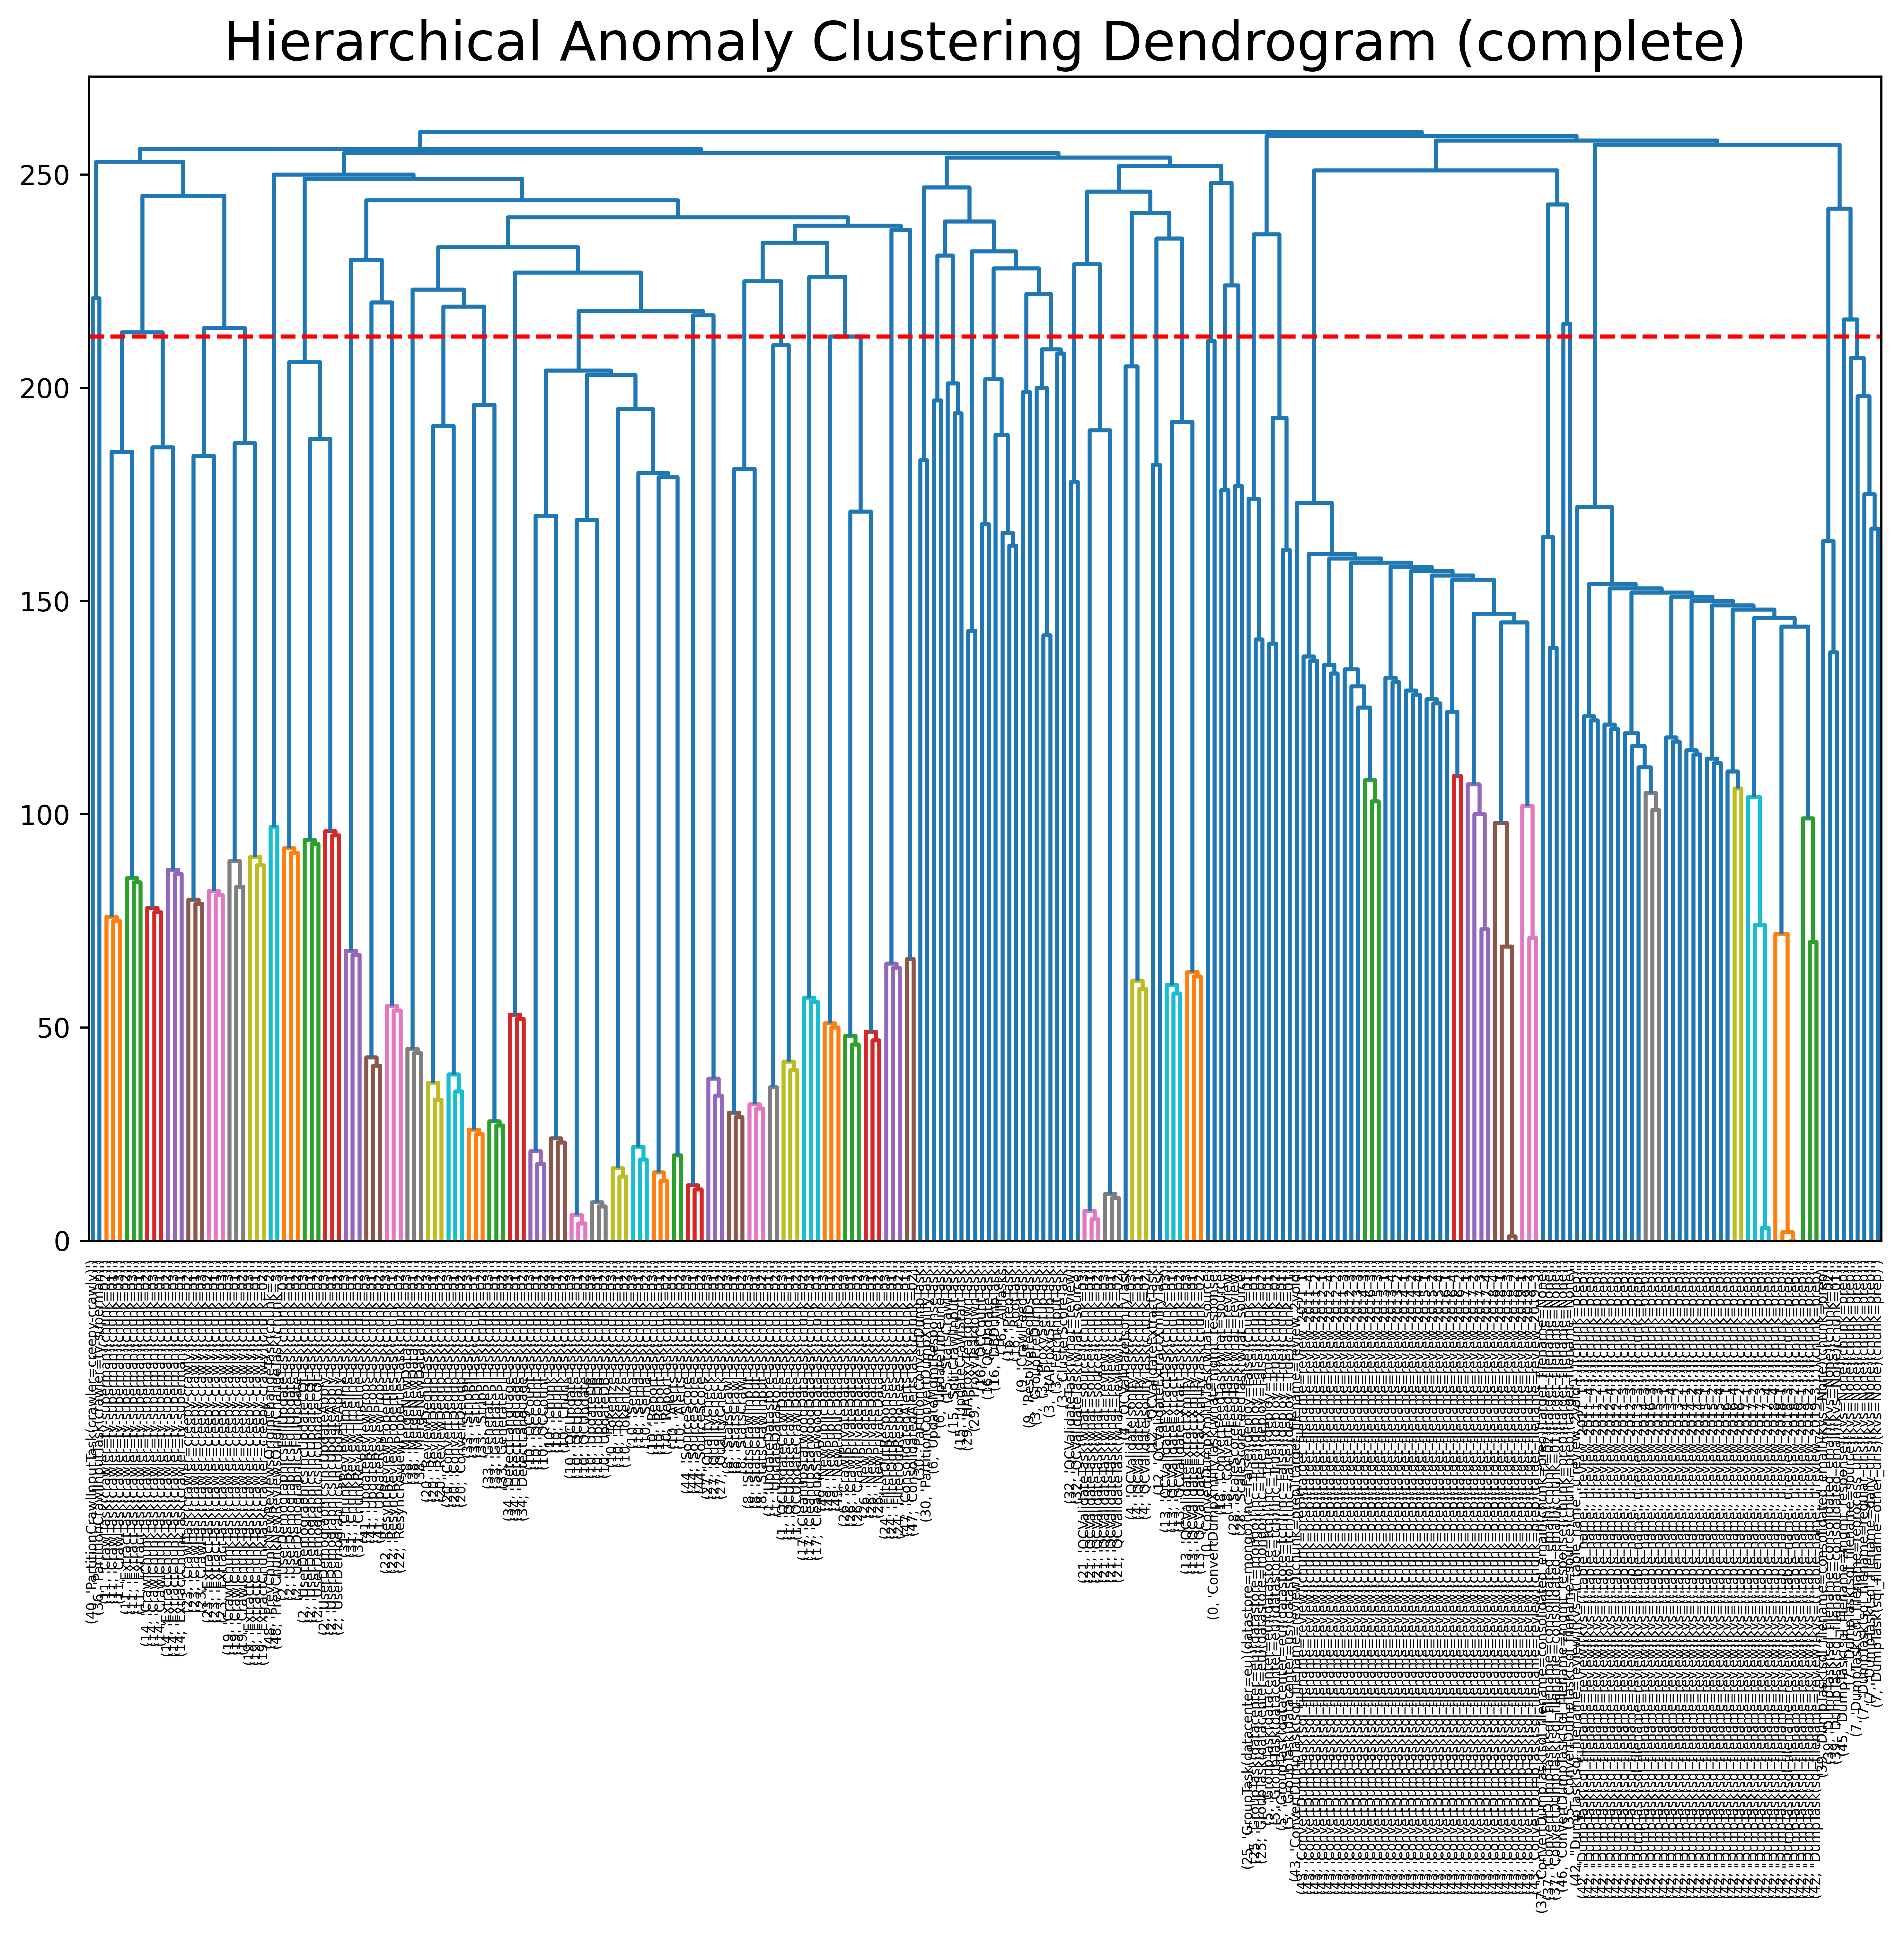


DONE


<Figure size 432x288 with 0 Axes>

In [12]:
dist_matrix = distance_matrix
tids = tid


print("Applying clustering")
#print(dist_matrix.shape)
tracs_clusters_labeled = list(zip(clustering.labels_, tids))
#print("Trace Clusters", tracs_clusters_labeled)
#print(tracs_clusters_labeled)

plt.clf()
# plotting
plt.figure(figsize=(12,8), dpi=600)
plt.title(f'Hierarchical Anomaly Clustering Dendrogram ({LINKAGE})', fontsize=20)
plot_dendrogram(clustering, labels=tracs_clusters_labeled, color_threshold=110)
plt.axhline(y=len(dist_matrix)-N_CLUSTERS, color='r', linestyle='--')
plt.show()
#plt.savefig('../plots/dendrogram_anomaly.png')
plt.clf()

print("\nDONE")

In [13]:
def find_matching_key(list_in, max_key_only = True):
  """
  returns the longest matching key in the list * with the highest frequency
  """
  keys = {}
  curr_key = ''

  # If n does not exceed max_n, don't bother adding
  max_n = 0

  for word in list(set(list_in)): #get unique values to speed up
    for i in range(len(word)):
      # Look up the whole word, then one less letter, sequentially
      curr_key = word[0:len(word)-i]
      # if not in, count occurance
      if curr_key not in keys.keys() and curr_key!='':
        n = 0
        for word2 in list_in:
          if curr_key in word2:
            n+=1
        # if large n, Add to dictionary
        if n > max_n:
          max_n = n
          keys[curr_key] = n
    # Finish the word
  # Finish for loop  
  if max_key_only:
    return max(keys, key=keys.get)
  else:
    return keys    

In [14]:
print(len(tracs_clusters_labeled))
tracs_clusters_labeled[:5]
clusters = pd.DataFrame(tracs_clusters_labeled, columns = ['cluster_id', 'concept:name'])
clusters.sort_values(by='cluster_id').head()

262


,cluster_id,concept:name
122,0,ConvertDumpXmlifyTask(what=mgmt_response)
119,0,ConvertDumpXmlifyTask(what=source)
214,1,UpdateDatastoreTask(chunk=02)
239,1,QCUpdateCrawlDateTask(chunk=03)
163,1,UpdateDatastoreTask(chunk=01)


In [15]:
pd.set_option('display.max_colwidth', None)

def get_cluster_name(cluster):
    if cluster['cluster_id'].unique() == [-1]:
        return 'NOISE'
    else:
        #print("Cluster:", cluster['cluster_id'].unique(), find_matching_key(cluster['concept:name']), "\n", cluster['concept:name'])
        return find_matching_key(cluster['concept:name'])+'_'+str(cluster['cluster_id'].unique()[0])

new_names = pd.DataFrame(clusters.groupby('cluster_id').apply(get_cluster_name), columns = ['common_act'])
new_names = new_names.join(clusters.set_index('cluster_id'), on='cluster_id').reset_index()

new_names.head()

,cluster_id,common_act,concept:name
0,0,ConvertDumpXmlifyTask(what=_0,ConvertDumpXmlifyTask(what=source)
1,0,ConvertDumpXmlifyTask(what=_0,ConvertDumpXmlifyTask(what=mgmt_response)
2,1,Update_1,QCUpdateCrawlDateTask(chunk=01)
3,1,Update_1,UpdateDatastoreTask(chunk=01)
4,1,Update_1,QCUpdateCrawlDateTask(chunk=02)


In [16]:
#df = df.reset_index()
match = df.join(new_names.set_index('concept:name'),  on='concept:name')
match.rename(columns={'case:concept:name':CASE_ID,
                   'concept:name':ACTIVITY_ID,
                   "time:timestamp": "start_timestamp"}, inplace=True)
match = match[['case', 'activity', 'start_time',
       'end_time', 'cluster_id', 'common_act']]

if len(match[match['common_act'].isnull()])==0:
    print("No common activity for",len(match['common_act'].unique()),"activities in ", len(match), " rows are empty.")

match['start_time']=match['start_time'].apply(lambda x: str(x).split('+')[0])
match['end_time']=match['end_time'].apply(lambda x: str(x).split('+')[0])

match.to_csv("../../perfsky/data/clustered_agg_edit_"+str(N_CLUSTERS)+"_daily.csv", sep=";",index=False)
match.sort_values(by='common_act')

No common activity for 50 activities in  61914  rows are empty.


,case,activity,start_time,end_time,cluster_id,common_act
26575,daily.2019-08-03_20-09-01,ExtractChunkTask(crawler=ty-superman)(chunk=02),2019-08-04 10:51:48,2019-08-04 10:51:48,14,C_14
30733,daily.2019-08-12_22-10-01,ExtractChunkTask(crawler=ty-superman)(chunk=03),2019-08-12 23:56:15,2019-08-12 23:56:15,14,C_14
30732,daily.2019-08-12_22-10-01,CrawlChunkTask(crawler=ty-superman)(chunk=01),2019-08-12 23:55:31,2019-08-12 23:55:32,14,C_14
30730,daily.2019-08-12_22-10-01,CrawlChunkTask(crawler=ty-superman)(chunk=03),2019-08-12 23:55:18,2019-08-12 23:55:18,14,C_14
46988,daily.2019-08-23_12-17-02,CrawlChunkTask(crawler=ty-superman)(chunk=01),2019-08-23 14:53:50,2019-08-23 14:53:50,14,C_14
...,...,...,...,...,...,...
16931,daily.2019-07-07_16-38-01,UserDemographicsIncUpdateCQLTask(chunk=02),2019-07-09 01:45:15,2019-07-09 01:56:39,2,UserDemographics_2
6930,daily.2019-09-09_01-34-02,UserDemographicsIncUpdateApplyTask(chunk=02),2019-09-10 23:46:00,2019-09-10 23:46:34,2,UserDemographics_2
16934,daily.2019-07-07_16-38-01,UserDemographicsIncUpdateApplyTask(chunk=02),2019-07-09 01:56:39,2019-07-09 02:04:47,2,UserDemographics_2
12872,daily.2019-09-04_23-23-01,UserDemographicsIncUpdateCQLTask(chunk=01),2019-09-05 17:25:03,2019-09-05 17:29:18,2,UserDemographics_2


# DBSCAN

In [17]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=80, min_samples=10).fit(distance_matrix)
clustered_obj = [a for a in clustering.labels_ if a > -1]
print(len(clustered_obj))

print(clustering.labels_)


218
[ 0 -1 -1 -1  0  0 -1 -1  1  0  2  1  0  1  0 -1 -1 -1 -1  2  1  0  0  2
  1  2  1 -1  3 -1  3  3  4  4  4  4  4  4  4  4  4  4  2  1  2  1  2  1
  2  1 -1  1  2  1  2  1  2  1  1  2  2  1  2  1  4  4  2  1  2  1  2  1
  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1
  2  1  2  1  2  1  2  1  2 -1 -1 -1 -1 -1  2 -1 -1 -1  2  3  0  3  0 -1
  0  0 -1  0  0  4  0  4  0  0  0  0 -1  0  0  3  3  3  3  3 -1  3  3  3
  3  3  3  3  3  3 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3 -1 -1  4
  4  3  4  4  3 -1  4 -1  0 -1  3  4 -1 -1 -1  3  4  3  4  3  3  3  3  3
 -1  3  3  3  3  3  3  3  3 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3
 -1 -1  3 -1 -1  3 -1  3  4  0  3  0  4  3  3  3  3 -1  3  3  3  3  3  3
  3  3  3  3  3  3  3  0  3  3  3  3  3  3  3  3 -1 -1 -1  3  3  0]


<Figure size 432x288 with 0 Axes>

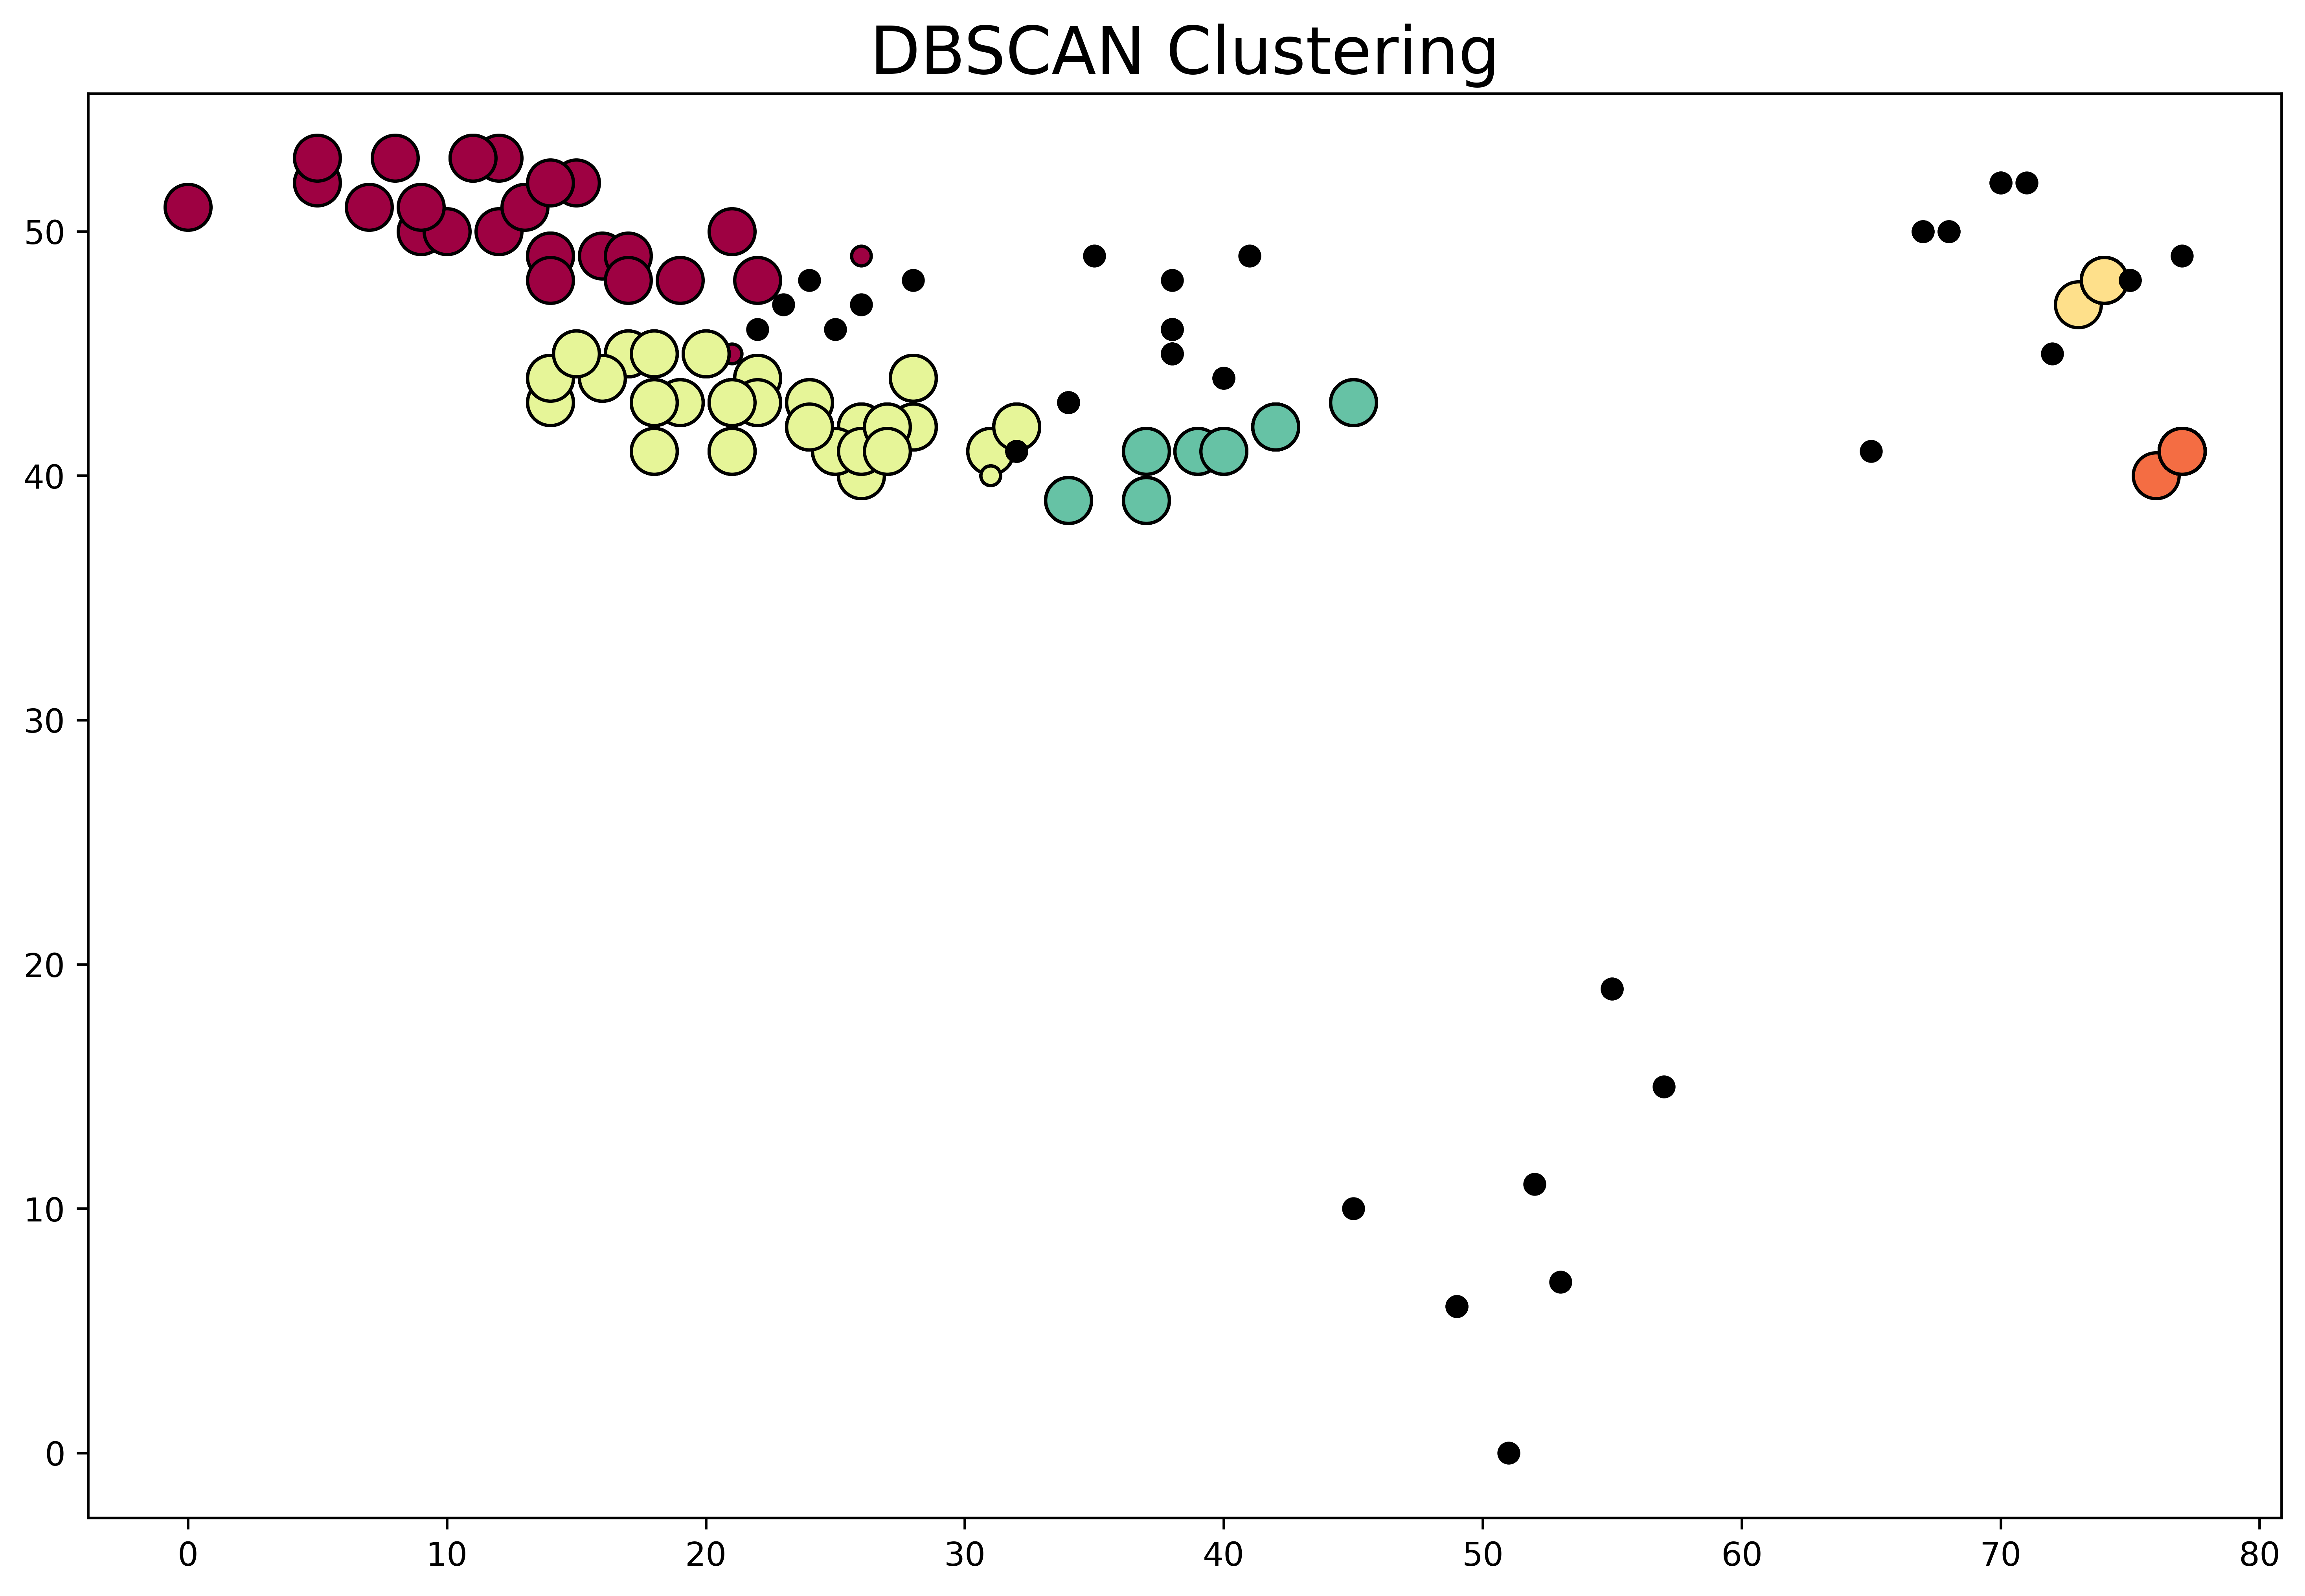

<Figure size 432x288 with 0 Axes>

In [18]:
labels = clustering.labels_
X = distance_matrix
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

plt.clf()
plt.figure(figsize=(12,8), dpi=600)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

plt.title("DBSCAN Clustering", fontsize=20)
#plt.savefig('../plots/dendrogram_anomaly.png')
plt.show()
plt.clf()

In [19]:
clusters_labeled = list(zip(clustering.labels_, tids))

In [20]:
clusters = pd.DataFrame(clusters_labeled, columns = ['cluster_id', 'concept:name'])
clusters.head()

new_names = pd.DataFrame(clusters.groupby('cluster_id').apply(get_cluster_name), columns = ['common_act'])
new_names = new_names.join(clusters.set_index('cluster_id'), on='cluster_id').reset_index()

new_names.head()

,cluster_id,common_act,concept:name
0,-1,NOISE,DumpTask(sql_filename=regular_urls)(kvs=None)(chunk=prep)
1,-1,NOISE,DumpTask(sql_filename=reprocess_urls)(kvs=None)(chunk=prep)
2,-1,NOISE,DumpTask(sql_filename=daily_urls)(kvs=None)(chunk=prep)
3,-1,NOISE,DumpTask(sql_filename=other_urls)(kvs=None)(chunk=prep)
4,-1,NOISE,DumpTask(sql_filename=mgmt_response)(kvs=None)(chunk=prep)


In [21]:
match = df.join(new_names.set_index('concept:name'),  on='concept:name')
match.rename(columns={'case:concept:name':CASE_ID,
                   'concept:name':ACTIVITY_ID,
                   "time:timestamp": "start_timestamp"}, inplace=True)
match = match[['case', 'activity', 'start_time',
       'end_time', 'cluster_id', 'common_act']]

if len(match[match['common_act'].isnull()])==0:
    print("Success for",len(match['common_act'].unique()),"activities in ", len(match), " rows")

match['start_time']=match['start_time'].apply(lambda x: str(x).split('+')[0])
match['end_time']=match['end_time'].apply(lambda x: str(x).split('+')[0])

#match.to_csv("../../perfsky/data/clustered_agg_edit_"+str(N_CLUSTERS)+"_daily.csv", sep=";",index=False)
match.sort_values(by='common_act')

Success for 6 activities in  61914  rows


,case,activity,start_time,end_time,cluster_id,common_act
0,daily.2019-09-24_05-05-02,AllTasks,2019-09-24 05:05:32,2019-09-24 16:55:33,0,C_0
21951,daily.2019-09-01_09-29-01,RootTask,2019-09-03 03:42:13,2019-09-03 03:43:13,0,C_0
21935,daily.2019-09-01_09-29-01,UpdateTimelineTask,2019-09-03 01:29:06,2019-09-03 01:47:37,0,C_0
21882,daily.2019-09-01_09-29-01,ProxyTeardownTask,2019-09-02 19:10:29,2019-09-02 19:21:36,0,C_0
21881,daily.2019-09-01_09-29-01,HAProxyTeardownTask,2019-09-02 19:10:29,2019-09-02 19:10:29,0,C_0
...,...,...,...,...,...,...
9441,daily.2019-09-16_19-44-01,NewPublicDataTask(chunk=03),2019-09-18 09:39:41,2019-09-18 09:44:19,3,T_3
13158,daily.2019-09-04_23-23-01,QualityCheckTask(chunk=02),2019-09-06 11:46:22,2019-09-06 11:46:24,3,T_3
26574,daily.2019-08-03_20-09-01,CleanupStarwoodDataTask(chunk=02),2019-08-04 10:51:08,2019-08-04 10:55:26,3,T_3
9440,daily.2019-09-16_19-44-01,ConvertDedupTask(chunk=03),2019-09-18 09:36:21,2019-09-18 09:39:41,3,T_3


In [413]:
def flatten(l):
    return [item for sublist in l for item in sublist]

#df.groupby('cluster_id').agg({'count': 'sum', 'variant_list': lambda x: ' '.join(x), 'case_ids': lambda x: ' '.join(x)})
df2 = df.groupby('cluster_id').agg({'count': 'sum', 'variant_list': lambda x: list(x), 'case_ids': lambda x: flatten(list(x))})
df2["unique_variants"] = df2.apply(lambda x: len(x["variant_list"]), axis=1)
df2

KeyError: 'cluster_id'

In [306]:
def trace_clustering(variants, distance, clu_method):
    distance_matrix, tid  = compute_distance_matrix(variants, distance)
    
    if clu_method == "agglomerative":
        clustering = AgglomerativeClustering(linkage=LINKAGE, affinity='precomputed', n_clusters=10).fit(distance_matrix)
        clustering.labels_
    elif clu_method == "dbscan":
        clustering = DBSCAN(eps=3, min_samples=2).fit(distance_matrix)
        clustering.labels_
    else:
        raise ValueError("Unknown distance")
         
    traces_clusters_labeled = list(zip(clustering.labels_, tids))
    
    return traces_clusters_labeled

def get_cluster_table(tracs_clusters_labeled):
    cluster_table = pd.DataFrame(tracs_clusters_labeled, columns = ['cluster_id', 'variant'])
   cluster_table = cluster_table.set_index('variant').join(variants_table.set_index('variant'))
    cluster_table["case_ids"] = cluster_table.apply(lambda x: [c.attributes['concept:name'] for c in pm4py.get_variants(log)[x.name]], axis=1)
    df2 = cluster_table.groupby('cluster_id').agg({'count': 'sum', 'variant_list': lambda x: list(x), 'case_ids': lambda x: flatten(list(x))})
    df2["unique_variants"] = df2.apply(lambda x: len(x["variant_list"]), axis=1)
    return df2

trace_clustering(variants, DISTANCE, ALGORITHM)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

In [27]:
for algo in ["agglomerative", "dbscan"]:
    for dist in ["jaro", "dam_lev", "lev", "lcs", "edit", "lev"]:
        traces_clusters_labeled = trace_clustering(variants, dist, algo)
        print(traces_clusters_labeled[0])

(1, 'AllTasks')


KeyboardInterrupt: 

In [ ]:
traces_clusters_labeled = trace_clustering(variants, "edit", "agglomerative")
df = get_cluster_table(traces_clusters_labeled)
df